# Bibliotecas

In [1]:
# Mudar diretório para chamar scripts com funções
import os
os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')

# Importar funções e flags definidas em flags.py e functions.py
from functions import *
from flags import * 

import psycopg2
from psycopg2 import OperationalError
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import HTML
import webbrowser
from collections import defaultdict
import networkx as nx

plt.rcParams['figure.figsize'] = (7,5)

# Ligação à base de dados

In [2]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

# R049 : Entidade Adjudicatária recebe número de adjudicações diretas acima de um determinado threshold de uma determinada Entidade Adjudicante

In [3]:
# IDs dos Ajustes Diretos
ajdir = cpv('72','Ajuste Direto Regime Geral')

cp = contratos(ajdir)

cp = cp.rename(columns={0:'ID', 1:'NrAnuncio', 3:'Prazo', 16:'DataPub', 17:'DataCel', 18:'PrecoContratual',20:'Adjudicante', 22:'Adjudicatária',59:'PrecoTotEfet'})

cp.PrecoContratual = cp.PrecoContratual.replace('None',0).astype(float)
cp.PrecoTotEfet = cp.PrecoTotEfet.replace('None',0).astype(float)

ajdir = cp.ID

In [4]:
for i,j in enumerate(col_names('contratos').values):
    print(i,j)

0 ['id']
1 ['n_anuncio']
2 ['anuncio_preco_base']
3 ['anuncio_proposalDeadline']
4 ['anuncio_cnccs']
5 ['anuncio_contractingProcedureAliasID']
6 ['anuncio_contractingProcedureId']
7 ['anuncio_drPublicationDate']
8 ['anuncio_dreNumber']
9 ['anuncio_dreSeries']
10 ['anuncio_impugnations']
11 ['anuncio_maximumEstimatedValueUnderFrameworkAgreement']
12 ['anuncio_reference']
13 ['anuncio_type']
14 ['tipo_procedimento']
15 ['objecto_contrato']
16 ['data_publicacao']
17 ['data_celebracao']
18 ['preco_contratual']
19 ['prazo_execucao']
20 ['entidade_adjudicante']
21 ['fundamentacao']
22 ['entidades_contratadas']
23 ['entidades_concorrentes']
24 ['url_anuncio']
25 ['url_peças_procedimento']
26 ['url_documentos']
27 ['criterios_ambientais']
28 ['cpv']
29 ['aquisitionStateMemberUE']
30 ['causesDeadlineChange']
31 ['causesPriceChange']
32 ['ccp']
33 ['centralizedProcedure']
34 ['closeDate']
35 ['cocontratantes']
36 ['contractStatus']
37 ['contractTypeCS']
38 ['contractTypes']
39 ['cpvsDesignation'

In [5]:
h(cp.head(1))

ID,NrAnuncio,2,Prazo,4,5,6,7,8,9,10,11,12,13,14,15,DataPub,DataCel,PrecoContratual,19,Adjudicante,21,Adjudicatária,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,PrecoTotEfet,60
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.0,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,0.0,1699382401


In [6]:
# Existe este número de ajustes diretos para CPVs 72XXXXXX
len(cp)

6781

In [7]:
# Separação dos elementos das colunas Adjudicante e Adjudicatária em 3 colunas Entidade-NIF-URL
pattern = r'^(?P<EntidadeAdjudicante>.*?)\s?\((?P<NIF1>[\w\.-]+)\)\((?P<URL1>.*?)\)$'
pattern1 = r'^(?P<EntidadeAdjudicataria>.*?)\s?\((?P<NIF2>[\w\.-]+)\)\((?P<URL2>.*?)\)$'

Df_extracted =  cp['Adjudicante'].str.extract(pattern)
Df_extracted1 = cp['Adjudicatária'].str.extract(pattern1)

# Correr linhas abaixo só uma vez
# Caso contrário está sempre a adicionar à dataframe as mesas colunas
cp = pd.concat([cp, Df_extracted], axis=1)
cp = pd.concat([cp, Df_extracted1], axis=1)

In [8]:
# Contagem do número de ocorrências para os NIFs de entidades adjudicantes
cp.NIF1.value_counts()

NIF1
502017368    128
501413197     80
501559094     65
500225680     60
501306099     57
            ... 
600038106      1
510841325      1
507142217      1
503203580      1
503281239      1
Name: count, Length: 1277, dtype: int64

In [9]:
# Contagem do número de ocorrências para os NIFs de entidades adjudicatárias
cp.NIF2.value_counts()

NIF2
-             376
501378669     196
502479418     111
504615947     107
504990926     101
             ... 
516166506       1
515846791       1
26-3836686      1
508896720       1
512059616       1
Name: count, Length: 1824, dtype: int64

In [10]:
# Conversão das colunas de data de celebração e publicação em datetime
cp.DataCel = pd.to_datetime(cp.DataCel)
cp.DataPub = pd.to_datetime(cp.DataPub)

In [11]:
# Número de contratos celebrados em 2023
len(cp[cp['DataCel'].dt.year == 2023])

3868

In [12]:
# Como há NIFs estrangeiros que contém as letras do país antes do número, temos de comparar strings e não inteiros
cp.NIF1 = cp.NIF1.astype(str)
cp.NIF2 = cp.NIF2.astype(str)

In [13]:
# Número de contratos públicos celebrados por ano
cp['DataCel'].dt.year.value_counts().sort_index(ascending = False)

DataCel
2023    3868
2022    2730
2021     119
2020      26
2019      26
2018       5
2017       1
2016       2
2015       3
2014       1
Name: count, dtype: int64

In [14]:
def nr_contrato(df,ano,nif):
    """
    Função que retorna o número de contratos celebrados/ganhos por uma determinada entidade adjudicatária num determinado ano

    Parâmetros:
         df : dataframe que contém o conjunto de contratos públicos
        ano : ano em que estamos interessados o número de contratos celebrados pela entidade
        nif : nif da entidade

    return:
        int : número de contratos públicos celebrados pela entidade com NIF=nif no ano de 'ano'
    """

    nr_cont = df[(df['DataCel'].dt.year == ano) & (df.NIF2 == nif)]

    return len(nr_cont)

In [15]:
def nr_contrato1(df,ano,nif1,nif2):
    """
    Função que retorna o número de contratos celebrados/ganhos por uma determinada entidade adjudicatária num determinado ano com 
    uma determinada entidade adjudicante

    Parâmetros:
         df  : dataframe que contém o conjunto de contratos públicos
        ano  : ano em que estamos interessados o número de contratos celebrados pela entidade
        nif1 : nif da entidade adjudicante
        nif2 : nif da entidade adjudicatária

    return:
        int : número de contratos públicos celebrados pela entidade com NIF=nif no ano de 'ano'
    """

    nr_cont = df[(df['DataCel'].dt.year == ano) & (df.NIF2 == nif2) & (df.NIF1 == nif1)]

    return len(nr_cont)

In [16]:
def nr_contrato2(df,ano,nif):
    """
    Função que retorna o número de contratos celebrados/ganhos por uma determinada entidade adjudicatária num determinado ano

    Parâmetros:
         df : dataframe que contém o conjunto de contratos públicos
        ano : ano em que estamos interessados o número de contratos celebrados pela entidade
        nif : nif da entidade

    return:
        int : número de contratos públicos celebrados pela entidade com NIF=nif no ano de 'ano'
    """

    nr_cont = df[(df['DataCel'].dt.year == ano) & (df.NIF1 == nif)]

    return len(nr_cont)

In [17]:
def valor_total(df,ano,nif):
    """
    Função que retorna o valor de todos os ajustes diretos atribuídos a uma entidade adjudicatária

    Parâmetros:
         df : dataframe que contém o conjunto de contratos públicos
        ano : ano em que estamos interessados o número de contratos celebrados pela entidade
        nif : nif da entidade

    return:
        int : número de contratos públicos celebrados pela entidade com NIF=nif no ano de 'ano'
    """

    preco = df.PrecoContratual[(df['DataCel'].dt.year == ano) & (df.NIF2 == nif)]

    return np.sum(preco)

In [18]:
def valor_total1(df,ano,nif1,nif2):
    """
    Função que retorna o valor de todos os ajustes diretos atribuídos a uma entidade adjudicatária

    Parâmetros:
         df : dataframe que contém o conjunto de contratos públicos
        ano : ano em que estamos interessados o número de contratos celebrados pela entidade
        nif : nif da entidade

    return:
        int : número de contratos públicos celebrados pela entidade com NIF=nif no ano de 'ano'
    """

    preco = df.PrecoContratual[(df['DataCel'].dt.year == ano) & (df.NIF2 == nif2) & (df.NIF1 == nif1)]

    return np.sum(preco)

In [19]:
nr_contrato(cp,2023,'504272179')

16

In [20]:
valor_total(cp,2023,'504272179')

1439597.18

### Análise dos Concursos Ganhos por entidade adjudicatária em 2023

In [21]:
print("Número de contratos públicos atribuídos ao conjunto de entidades adjudicatárias\n\n    NIF \t Nr de Contratos 2023 \t\t Montante Total\n")

for i in (cp.NIF2.value_counts().index):
    print(i,'\t\t', nr_contrato(cp,2023,i), '\t\t\t', np.round(valor_total(cp,2023,i),2), '\t\t\t', np.round(valor_total(cp,2023,i)/nr_contrato(cp,2023,i),2))

Número de contratos públicos atribuídos ao conjunto de entidades adjudicatárias

    NIF 	 Nr de Contratos 2023 		 Montante Total

- 		 222 			 2689319.83 			 12114.05
501378669 		 120 			 2940166.54 			 24501.39
502479418 		 66 			 4047734.1 			 61329.3
504615947 		 51 			 1471685.21 			 28856.57
504990926 		 62 			 2566844.44 			 41400.72
505331187 		 65 			 1190179.07 			 18310.45
511135610 		 29 			 357804.96 			 12338.1
501941231 		 37 			 1246121.82 			 33678.97
504551221 		 39 			 1708149.97 			 43798.72
505141019 		 41 			 362102.43 			 8831.77
501989978 		 36 			 1691483.33 			 46985.65
503140600 		 27 			 1051768.09 			 38954.37
502413603 		 25 			 394409.78 			 15776.39
503754803 		 33 			 682611.4 			 20685.19
502246995 		 30 			 869962.13 			 28998.74
506176142 		 29 			 1723453.33 			 59429.43
502604751 		 24 			 322780.88 			 13449.2
502250259 		 25 			 945083.3 			 37803.33
510728189 		 26 			 985229.81 			 37893.45
503526568 		 20 			 185768.36 			 9288.42
508496870 		

/tmp/ipykernel_110214/2756230071.py:4: RuntimeWarning: invalid value encountered in scalar divide
  print(i,'\t\t', nr_contrato(cp,2023,i), '\t\t\t', np.round(valor_total(cp,2023,i),2), '\t\t\t', np.round(valor_total(cp,2023,i)/nr_contrato(cp,2023,i),2))


511021380 		 4 			 532226.77 			 133056.69
508851360 		 1 			 3173.0 			 3173.0
501178503 		 4 			 76388.2 			 19097.05
502120070 		 5 			 1417907.0 			 283581.4
504143603 		 5 			 335197.0 			 67039.4
503904040 		 5 			 187509.0 			 37501.8
501926003 		 3 			 73490.65 			 24496.88
502309440 		 4 			 2192146.0 			 548036.5
504904493 		 4 			 56214.42 			 14053.6
501467939 		 2 			 39844.6 			 19922.3
513229248 		 3 			 101590.0 			 33863.33
507817842 		 3 			 32062.6 			 10687.53
501893776 		 4 			 50106.0 			 12526.5
513378030 		 4 			 49440.0 			 12360.0
513750363 		 5 			 39475.12 			 7895.02
514338938 		 5 			 41060.28 			 8212.06
509844456 		 2 			 22600.0 			 11300.0
507477740 		 1 			 10995.63 			 10995.63
510603912 		 3 			 41815.0 			 13938.33
502317124 		 3 			 105395.6 			 35131.87
502586745 		 2 			 129500.0 			 64750.0
506882918 		 3 			 15250.0 			 5083.33
503882887 		 2 			 36375.0 			 18187.5
506303810 		 3 			 32485.0 			 10828.33
508202531 		 5 			 62300.0 			 12460.0

In [22]:
nif1 = '501378669'
nif2 = '502479418' 
nif3 = '504615947' 

<br>
<br>

**CASO 1 :** 501378669 ( Associação de Informática da Região Centro )

NIF1 : Entidade adjudicante que celebrou contrato com AIRC

AjustesDiretos : Nr de ajustes diretos celebrados em 2023

MontanteTotal : Montante total dos ajustes diretos celebrados

AjustesDiretosTotais : Nr de Ajustes diretos adjudicados pela empresa com NIF1

Rácio : Rácio de ajustes diretos adjudicados à empresa com NIF2 de todos os ajustesdiretos adjudicados pela empresa adjudicante

In [23]:
print('NIF1 \t\t AjustesDiretos \t MontanteTotal \t AjustesDiretosTotais \t Rácio ')

for i in cp['NIF1'].loc[(cp['NIF2'] == '501378669') & (cp['DataCel'].dt.year == 2023)].value_counts().index:
    print(i, '\t\t', nr_contrato1(cp,2023,i,nif1), '\t\t', valor_total1(cp,2023,i,nif1), '\t\t', nr_contrato2(cp,2023,i),
         '\t\t',  np.round(nr_contrato1(cp,2023,i,nif1)/nr_contrato2(cp,2023,i),1)*100)

NIF1 		 AjustesDiretos 	 MontanteTotal 	 AjustesDiretosTotais 	 Rácio 
508354617 		 3 		 24224.0 		 12 		 20.0
510832890 		 3 		 17756.0 		 8 		 40.0
501138960 		 2 		 39001.0 		 17 		 10.0
505931192 		 2 		 57231.0 		 5 		 40.0
503539473 		 2 		 53563.0 		 8 		 20.0
506605949 		 2 		 32079.0 		 4 		 50.0
502173653 		 2 		 81698.0 		 12 		 20.0
506772446 		 2 		 45907.0 		 2 		 100.0
506801969 		 2 		 32304.0 		 5 		 40.0
501144218 		 2 		 72506.0 		 5 		 40.0
506826961 		 2 		 25257.0 		 3 		 70.0
506818829 		 2 		 32189.0 		 3 		 70.0
501120149 		 2 		 36621.54 		 3 		 70.0
505187531 		 2 		 215359.0 		 22 		 10.0
505592959 		 2 		 32177.0 		 2 		 100.0
501143734 		 1 		 23364.0 		 4 		 20.0
501155996 		 1 		 26621.0 		 2 		 50.0
502173297 		 1 		 5279.0 		 5 		 20.0
507103742 		 1 		 23277.0 		 3 		 30.0
506783146 		 1 		 25418.0 		 4 		 20.0
501937471 		 1 		 21381.0 		 4 		 20.0
502106506 		 1 		 8822.0 		 3 		 30.0
506876330 		 1 		 25768.0 		 2 		 50.0
512043701 		 1 		 28884.0 

<br>
<br>

**CASO 2 :** 502479418 ( Glintt - Healthcare Solutions, S.a )

In [24]:
print('NIF1 \t\t AjustesDiretos \t MontanteTotal \t AjustesDiretosTotais \t Rácio ')

for i in cp['NIF1'].loc[(cp['NIF2'] == '502479418') & (cp['DataCel'].dt.year == 2023)].value_counts().index:
    print(i, '\t\t', nr_contrato1(cp,2023,i,nif2), '\t\t', valor_total1(cp,2023,i,nif2), '\t\t', nr_contrato2(cp,2023,i),
         '\t\t',  np.round(nr_contrato1(cp,2023,i,nif2)/nr_contrato2(cp,2023,i),1)*100)

NIF1 		 AjustesDiretos 	 MontanteTotal 	 AjustesDiretosTotais 	 Rácio 
506362299 		 4 		 369574.11 		 20 		 20.0
508318262 		 4 		 116625.49 		 19 		 20.0
509822940 		 3 		 170775.52 		 36 		 10.0
510103448 		 3 		 430791.99 		 18 		 20.0
508142156 		 3 		 198620.87 		 31 		 10.0
509821197 		 3 		 253844.47 		 18 		 20.0
507618319 		 3 		 84663.0 		 25 		 10.0
506361462 		 2 		 50116.76 		 12 		 20.0
506361390 		 2 		 125717.68 		 20 		 10.0
508094461 		 2 		 64039.67 		 11 		 20.0
508481287 		 2 		 190101.43 		 20 		 10.0
508786193 		 2 		 86697.38 		 27 		 10.0
506361659 		 2 		 88812.26000000001 		 6 		 30.0
506361608 		 2 		 97091.44 		 17 		 10.0
506361616 		 2 		 44259.18 		 31 		 10.0
515545180 		 2 		 35762.5 		 7 		 30.0
508085888 		 1 		 50250.55 		 7 		 10.0
501626123 		 1 		 6153.38 		 6 		 20.0
600012662 		 1 		 34233.2 		 13 		 10.0
510116477 		 1 		 37720.0 		 1 		 100.0
509932584 		 1 		 138503.85 		 10 		 10.0
510745997 		 1 		 52681.2 		 8 		 10.0
506361381 		 1 		 34

<br>
<br>

**CASO 3 :** 504615947 ( Meo - Serviços de Comunicações e Multimédia S.a ) 

In [25]:
print('NIF1 \t\t AjustesDiretos \t MontanteTotal \t AjustesDiretosTotais \t Rácio ')

for i in cp['NIF1'].loc[(cp['NIF2'] == '504615947') & (cp['DataCel'].dt.year == 2023)].value_counts().index:
    print(i, '\t\t', nr_contrato1(cp,2023,i,nif3), '\t\t', np.round(valor_total1(cp,2023,i,nif3),2), '\t\t', nr_contrato2(cp,2023,i),
         '\t\t',  np.round(nr_contrato1(cp,2023,i,nif3)/nr_contrato2(cp,2023,i),2)*100)

NIF1 		 AjustesDiretos 	 MontanteTotal 	 AjustesDiretosTotais 	 Rácio 
506967107 		 2 		 22875.2 		 2 		 100.0
502017368 		 2 		 21065.32 		 78 		 3.0
506818837 		 2 		 13908.96 		 7 		 28.999999999999996
501394192 		 2 		 7458.0 		 7 		 28.999999999999996
671001264 		 2 		 8804.12 		 3 		 67.0
680033629 		 2 		 20049.11 		 8 		 25.0
501306870 		 1 		 8100.0 		 5 		 20.0
600035972 		 1 		 4997.63 		 1 		 100.0
509540716 		 1 		 624875.04 		 27 		 4.0
515545236 		 1 		 6111.36 		 5 		 20.0
506037258 		 1 		 18189.72 		 4 		 25.0
506855368 		 1 		 8779.68 		 2 		 50.0
516160893 		 1 		 8920.08 		 1 		 100.0
508977495 		 1 		 2008.54 		 1 		 100.0
506697339 		 1 		 12195.0 		 6 		 17.0
511228848 		 1 		 19691.76 		 8 		 12.0
502678917 		 1 		 19980.0 		 3 		 33.0
507606787 		 1 		 14860.32 		 3 		 33.0
511152302 		 1 		 16290.72 		 2 		 50.0
503279765 		 1 		 11448.0 		 4 		 25.0
505311313 		 1 		 17550.0 		 6 		 17.0
512012814 		 1 		 24070.8 		 3 		 33.0
500122237 		 1 		 13631.68 		 10

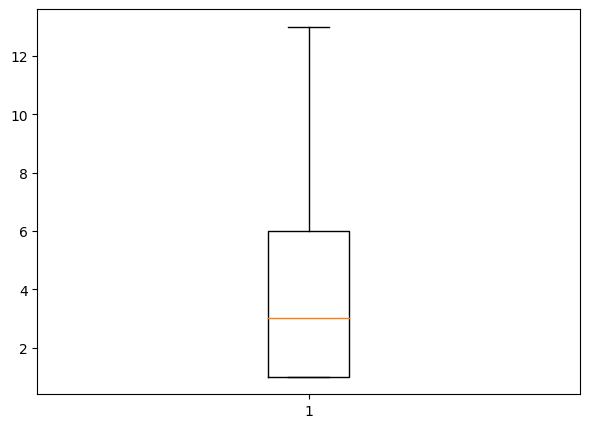

In [51]:
plt.boxplot(cp.NIF1.value_counts().values, showfliers=False)
plt.show()

In [55]:
cp.NIF1.value_counts().describe()

count    1277.000000
mean        5.310102
std         8.348934
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       128.000000
Name: count, dtype: float64

In [88]:
def rf49(df,id):
    """
    """

    # NIF entidade adjudicante
    n1 = df[df['ID'] == id].NIF1.values[0]

    # NIF entidade convidada
    n2 = df[df['ID'] == id].NIF2.values[0]

    # Número de ajustes diretos celebrados entre nif1 e nif2
    nc = len(cp[(cp.NIF1 == n1) & (cp.NIF2 == n2)])

    # Número de ajustes diretos celebrados pelo nif1
    nc1 = len(cp[(cp.NIF1 == n1)])

    # Rácio de contratos
    r = nc/nc1 * 100

    
    
    
    return n1,n2, nc, nc1, r

In [89]:
rf49(cp, '10323628')

('505072947', '504656767', 1, 5, 20.0)